### Q2: Determine if a player is under or over paid based on value and overall rating.

### Importing Modules

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

### Make a copy of the relevant columns

In [48]:
df = pd.read_csv("fifa_cleaned.csv")
# Keeping the string versions of wage and value
df2 = df[["Name", '↓OVA', 'Value', 'Value_int', 'Wage', 'Wage_amt', 'Field Position', 'Age']].copy()

In [49]:
# checking for missing values
print("Missing Values:")
print(df2.isnull().sum())
# Presence of 0 Wage in the database
print((df2['Wage_amt'] == 0).any().sum())

Missing Values:
Name              0
↓OVA              0
Value             0
Value_int         0
Wage              0
Wage_amt          0
Field Position    0
Age               0
dtype: int64
1


### Filter for Invalid Data

In [50]:
# Filter out invalid data: Wage_amt > 0, Value_int > 0, Age < 40
df2 = df2[(df2['Wage_amt'] > 0) & (df2['Value_int'] > 0) & (df2['Age'] < 40)].copy()

In [51]:
# Re-check for wage_amt = 0
(df2["Wage_amt"] == 0).any()

np.False_

### Log Transform to handle skewness

In [52]:
df2["Log_Wage"] = np.log1p(df2["Wage_amt"])
df2["Log_Value"] = np.log1p(df2["Value_int"])

In [53]:
df2.head()

,Name,↓OVA,Value,Value_int,Wage,Wage_amt,Field Position,Age,Log_Wage,Log_Value
0,L. Messi,93,€103.5M,103500000.0,€560K,560000.0,ATT,33,13.235694,18.455082
1,Cristiano Ronaldo,92,€63M,63000000.0,€220K,220000.0,ATT,35,12.301387,17.958645
2,J. Oblak,91,€120M,120000000.0,€125K,125000.0,GK,27,11.736077,18.603002
3,K. De Bruyne,91,€129M,129000000.0,€370K,370000.0,MID,29,12.821261,18.675323
4,Neymar Jr,91,€132M,132000000.0,€270K,270000.0,ATT,28,12.506181,18.698312


### Summary Statistics

In [54]:
print("Summary Statistics:")
print(df2[['↓OVA', 'Value_int', 'Wage_amt', 'Age', 'Log_Wage', 'Log_Value']].describe())


Summary Statistics:
               ↓OVA     Value_int      Wage_amt           Age      Log_Wage  \
count  18716.000000  1.871600e+04   18716.00000  18716.000000  18716.000000   
mean      65.678724  2.905060e+06    9213.79034     25.119470      8.124796   
std        6.970819  7.731462e+06   19814.96305      4.656923      1.354477   
min       47.000000  9.000000e+03     500.00000     16.000000      6.216606   
25%       61.000000  4.750000e+05    1000.00000     21.000000      6.908755   
50%       66.000000  9.750000e+05    3000.00000     25.000000      8.006701   
75%       70.000000  2.000000e+06    9000.00000     28.000000      9.105091   
max       93.000000  1.855000e+08  560000.00000     39.000000     13.235694   

          Log_Value  
count  18716.000000  
mean      13.888288  
std        1.240581  
min        9.105091  
25%       13.071072  
50%       13.790194  
75%       14.508658  
max       19.038565  


### Plotting a Histogram to show the distribution

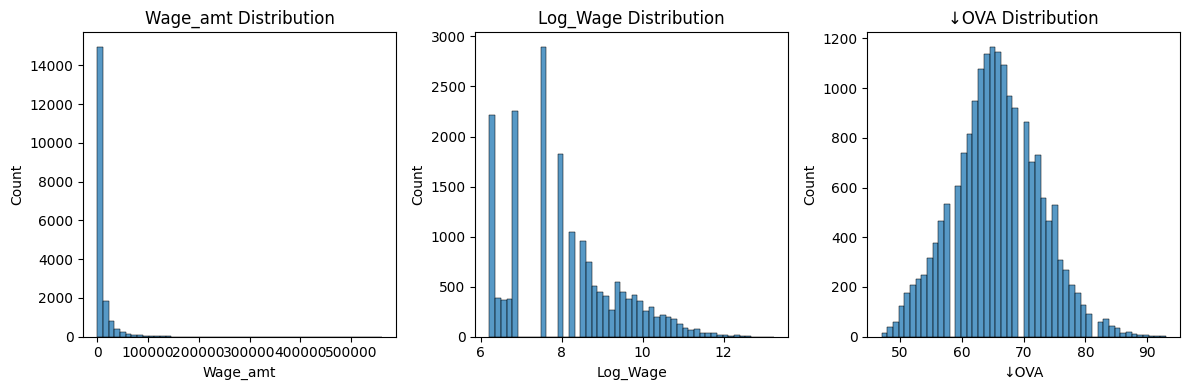

In [55]:
# Visualize distributions
plt.figure(figsize=(12, 4))
# subplot(nrow, ncol, index)
plt.subplot(1, 3, 1) # used to arrange the smaller fig in the same screen
sns.histplot(df2['Wage_amt'], bins=50)
plt.title('Wage_amt Distribution')
plt.subplot(1, 3, 2)
sns.histplot(df2['Log_Wage'], bins=50)
plt.title('Log_Wage Distribution')
plt.subplot(1, 3, 3)
sns.histplot(df2['↓OVA'], bins=50)
plt.title('↓OVA Distribution')
plt.tight_layout()
plt.show()

### Correlation between variables, value, OVA and wage

In [56]:
print("\nCorrelations:")
corr_matrix = df2[['↓OVA', 'Log_Value', 'Log_Wage', 'Age']].corr()
print(corr_matrix)


Correlations:
               ↓OVA  Log_Value  Log_Wage       Age
↓OVA       1.000000   0.892297  0.789725  0.471096
Log_Value  0.892297   1.000000  0.758483  0.064163
Log_Wage   0.789725   0.758483  1.000000  0.309126
Age        0.471096   0.064163  0.309126  1.000000


### Analysis of Correlation Results
> (Overall Rating, Log_Value), (Overall Rating, Log_Wage) and (Log_Value, Log_Wage) have a highly positive correlation coefficient.

> Age, however, only have a moderately positive correlation coefficient with the other variables with the exception of Log_Value (0.064163) (< 0.5 for all comparisons).

### Visualisation of the correlations

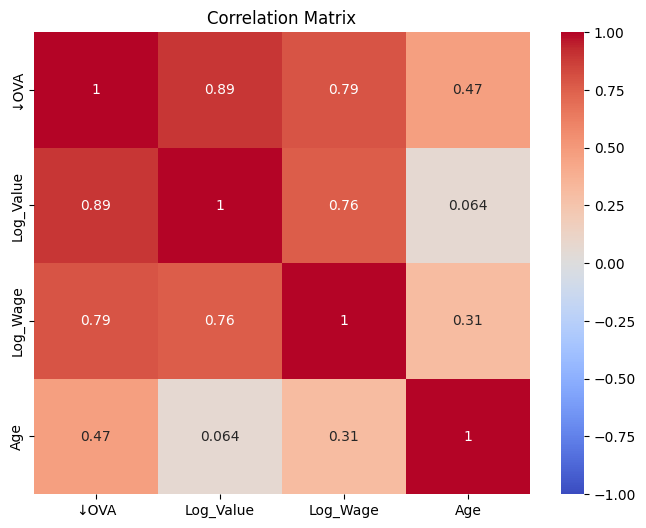

In [57]:
plt.figure(figsize=(8,6))
# vmin/vmax are values to anchor the coloramp, otherwise inferred
# coolwarm is a diverging color option to denote the map colours
# annot will take a boolean or rect dataset which writes the data value in each cell
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

### Analysis: whether or not to keep Age as a factor?

- Age still contributes to explaining wage variation, it may account factors like leadership roles, experience and contract history.
- Age effects are still statistically significant considering the large size of the dataset although it may be less impact than overall ratings and player value.
- Complements overall rating and player value, captures wage variations not accounted by the 2 factors previously mentioned.

In [58]:
df2

,Name,↓OVA,Value,Value_int,Wage,Wage_amt,Field Position,Age,Log_Wage,Log_Value
0,L. Messi,93,€103.5M,103500000.0,€560K,560000.0,ATT,33,13.235694,18.455082
1,Cristiano Ronaldo,92,€63M,63000000.0,€220K,220000.0,ATT,35,12.301387,17.958645
2,J. Oblak,91,€120M,120000000.0,€125K,125000.0,GK,27,11.736077,18.603002
3,K. De Bruyne,91,€129M,129000000.0,€370K,370000.0,MID,29,12.821261,18.675323
4,Neymar Jr,91,€132M,132000000.0,€270K,270000.0,ATT,28,12.506181,18.698312
...,...,...,...,...,...,...,...,...,...,...
18974,Xia Ao,47,€100K,100000.0,€1K,1000.0,DEF,21,6.908755,11.512935
18975,B. Hough,47,€130K,130000.0,€500,500.0,MID,17,6.216606,11.775297
18976,R. McKinley,47,€120K,120000.0,€500,500.0,MID,18,6.216606,11.695255
18977,Wang Zhen'ao,47,€100K,100000.0,€2K,2000.0,ATT,20,7.601402,11.512935


### Model Selection and Setup

> Use Random Forest Regressor to handle non-linearity and interactions between the 3 independent variables (OVA, Log_Value and Age)

> Using position specific models to determine if a player is overpaid

In [59]:
# Dictionary to store models 
pos_models = {}
pos_metrics = {}
pos_predictions = {}

### Developing the model

In [60]:
positions = ["ATT", "MID", "DEF", "GK"]
for pos in positions:
    # filter those rows where position is equal to pos
    # Create a new DataFrame variable name using globals() or locals()
    vars()[f'df_{pos}'] = df2[df2['Field Position'] == pos].copy()
    df_pos = vars()[f'df_{pos}']  # Reference the new DataFrame

    # ensure that there is sufficient data
    if len(df_pos) < 50:
        print("Insufficient data for model creation")
        continue # move on to the next position, break will exit the for loop completely

    # features (Independent variables)
    X = df_pos[["Log_Value", "↓OVA", "Age"]]

    # dependent variables
    y = df_pos["Log_Wage"]

    # Splitting the data into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the random forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict and Evaluate (on the test data)
    y_pred = model.predict(X_test)
    r2_result = r2_score(y_test, y_pred)
    rmse_result = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Current Position: {pos}")
    print(f"r2: {r2_result}, rmse: {rmse_result}")
    pos_metrics[pos] = {'R²': r2_result, 'RMSE': rmse_result}

    # Predict for all players in the position
    df_pos["Predicted_Log_Wage"] = model.predict(X)

    # finding the Predicted Wage and Residual Wage
    df_pos["Predicted_Wage"] = np.expm1(df_pos["Predicted_Log_Wage"])
    df_pos["Residual_Wage"] = df_pos["Wage_amt"] - df_pos["Predicted_Wage"]

    # assign a status
    df_pos["Pay_Status"] = np.where(df_pos["Residual_Wage"] > 0, "Overpaid", "Underpaid")
    df_pos["Pay_Status"] = np.where(abs(df_pos["Residual_Wage"]) < df_pos["Wage_amt"] * 0.1, "Fairly Paid", df_pos["Pay_Status"])

    # assigning to the dictionary
    pos_predictions[pos] = df_pos

Current Position: ATT
r2: 0.6055866233876538, rmse: 0.865165446794456
Current Position: MID
r2: 0.6226416453514526, rmse: 0.8419973243923687
Current Position: DEF
r2: 0.6361547381158665, rmse: 0.8177154574259523
Current Position: GK
r2: 0.5414720716288832, rmse: 0.8799499117623193


In [61]:
# Print top overpaid and underpaid players for each position
for pos in pos_predictions.keys():
    list = pos_predictions[pos][['Name', '↓OVA', 'Value_int', 'Wage_amt', 'Predicted_Wage', 'Residual_Wage', 'Pay_Status']].sort_values('Residual_Wage', ascending=False)
    print(f"\nTop 5 Overpaid Players ({pos}):")
    print(list[0:4][['Name', '↓OVA', 'Residual_Wage']])
    print(f"\nTop 5 Underpaid Players ({pos}):")
    print(list[-5:][['Name', '↓OVA', 'Residual_Wage']])


Top 5 Overpaid Players (ATT):
              Name  ↓OVA  Residual_Wage
0         L. Messi    93  317456.640850
28    A. Griezmann    87  135076.333678
429  Lucas Vázquez    80  128444.356397
140      E. Cavani    84  124927.718774

Top 5 Underpaid Players (ATT):
               Name  ↓OVA  Residual_Wage
507   Júnior Moraes    79  -35873.341509
81       L. Insigne    85  -38013.546706
45        L. Suárez    87  -38058.378767
307  Iñaki Williams    81  -38265.467294
130      Iago Aspas    84  -72096.002164

Top 5 Overpaid Players (MID):
              Name  ↓OVA  Residual_Wage
192       Coutinho    83  135736.012752
226  Marco Asensio    82  103409.120757
97       M. Pjanić    85   92625.691886
44       L. Modrić    87   77983.054142

Top 5 Underpaid Players (MID):
           Name  ↓OVA  Residual_Wage
334        Suso    81  -46121.617231
230   Q. Promes    82  -50549.927124
148  D. Zakaria    83  -62056.181445
276   Cucurella    81  -62873.476279
161        Rafa    83  -64945.234278

Top 5

### Visualization Graph for Attacking Players

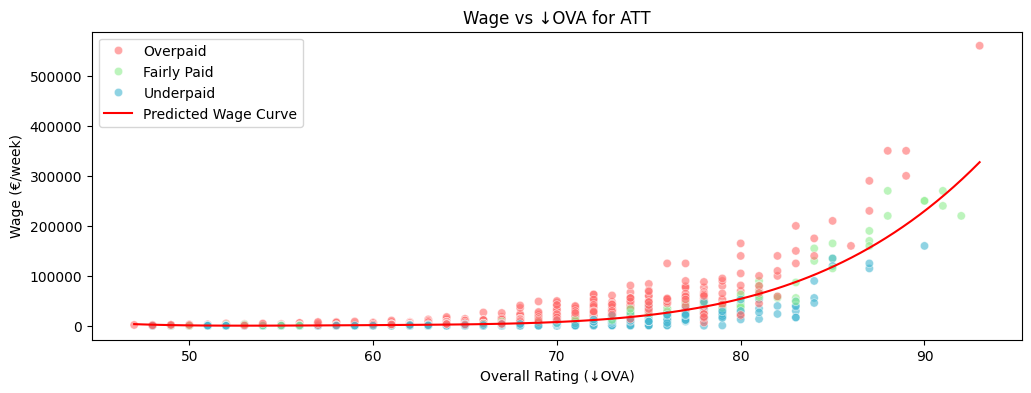

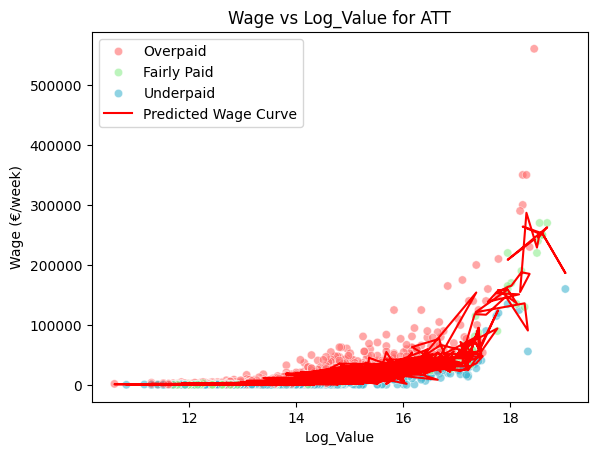

In [ ]:
plt.figure(figsize=(12, 4))

pos_to_plot = "ATT"
# Scatterplots
sns.scatterplot(data=pos_predictions[pos_to_plot], x='↓OVA', y='Wage_amt', hue='Pay_Status', 
                palette={'Overpaid': '#FF6B6B', 'Fairly Paid': '#90EE90', 'Underpaid': '#45B7D1'}, alpha=0.6)

# Fit a polynomial curve
coeffs = np.polyfit(pos_predictions[pos_to_plot]['↓OVA'], pos_predictions[pos_to_plot]['Predicted_Wage'], 4)
poly = np.poly1d(coeffs)
ova_range = np.linspace(min(pos_predictions[pos_to_plot]['↓OVA']), max(pos_predictions[pos_to_plot]['↓OVA']), 100)
plt.plot(ova_range, poly(ova_range), color='red', label='Predicted Wage Curve')

plt.title(f'Wage vs ↓OVA for {pos_to_plot}')
plt.xlabel('Overall Rating (↓OVA)')
plt.ylabel('Wage (€/week)')
plt.legend()
plt.show()

pos_to_plot = "ATT"
sns.scatterplot(data=pos_predictions[pos_to_plot], x='Log_Value', y='Wage_amt', hue='Pay_Status', 
                palette={'Overpaid': '#FF6B6B', 'Fairly Paid': '#90EE90', 'Underpaid': '#45B7D1'}, alpha=0.6)
plt.plot(pos_predictions[pos_to_plot]['Log_Value'], pos_predictions[pos_to_plot]['Predicted_Wage'], color='red', label='Predicted Wage Curve')
plt.title(f'Wage vs Log_Value for {pos_to_plot}')
plt.xlabel('Log_Value')
plt.ylabel('Wage (€/week)')
plt.legend()
plt.show()